In [1]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import re
import os
%matplotlib inline

# Define paths

Accross the analysis the following names are used for the 3 screens
- ova == Hippo RNAi Ovariole Number screen
- fec == Hippo RNAi EggLaying screen
- xRNAi == EggLaying screen

In [2]:
# Define the path where all the primary data are

data = '../Data/'

# Result path containing all the results from the analysisi
resultpath = '../Results/'

# Load the datasets

In [3]:
# Loading the raw data for the 3 screens
# HippoRNAi EggLaying
hipo_fec = pd.read_csv(os.path.join(data,'Screen', 'Raw', 'Raw_EggLaying_HpoRNAi_Pred.csv'))
# HippoRNAi Ovariole Number
hipo_ova = pd.read_csv(os.path.join(data,'Screen', 'Raw', 'Raw_Ova_HpoRNAi_Pred.csv'))
# Egg Laying
xRNAi_fec = pd.read_csv(os.path.join(data,'Screen', 'Raw', 'Raw_EggLaying_Pred.csv'))

# And we load the signaling table that contains the mapping for all the FbID to signaling pathway
signaling = pd.read_csv(os.path.join(data,'signaling.csv'))

In [4]:
len(xRNAi_fec['FbID'].unique())

43

## Checking that we have the correct number of genes

In [5]:
# Assert that the number of gene in the screen, that are in the signaling table (which contains the gene tested) is 463
assert(len(hipo_fec['FbID'].unique()) == 43)

In [6]:
# Assert that the number of gene in the screen, that are in the signaling table (which contains the gene tested) is 273
assert len(hipo_ova['FbID'].unique()) == 43

In [7]:
# Assert that the number of gene in the screen, that are in the signaling table (which contains the gene tested) is 273
assert len(xRNAi_fec['FbID'].unique()) == 43

# Cleaning Ovariole Number data
## Tidy Data for Ovariole Database

In [8]:
# Create the mapping table for Fly ID to column name
map_FlyId = {'Fly 1':1,
             'Fly 1.1':1,
             'Fly 2':2,
             'Fly 2.1':2,
             'Fly 3':3,
             'Fly 3.1':3,
             'Fly 4':4,
             'Fly 4.1':4,
             'Fly 5':5,
             'Fly 5.1':5,
             'Fly 6':6,
             'Fly 6.1':6,
             'Fly 7':7,
             'Fly 7.1':7,
             'Fly 8':8,
             'Fly 8.1':8,
             'Fly 9':9,
             'Fly 9.1':9,
             'Fly 10':10,
             'Fly 10.1':10
            }

In [9]:
# Here we Tidy the data, aka we transform the 2 entry table into a tidy dataframe format
# Create an array to hold the reults

result = []
# For each row
for i in range(len(hipo_ova)):
    # collect meta information 
    FbID = hipo_ova['FbID'][i]
    Condition = hipo_ova['Condition'][i]
    batch = hipo_ova['BATCH'][i]
    # For each ovary
    for ovary in map_FlyId:
        # Define FlyID
        FlyID = map_FlyId[ovary]
        # Collect ovariole number
        ovanb = hipo_ova[ovary][i]
        # Add the result as a new line to the result array
        result.append([Condition, batch, FbID, FlyID, ovanb])
        
# Save the array into a dataframe 
hipo_ova_clean = pd.DataFrame(result, columns=['Gene', 'Batch','FbID','FlyId','OvarioleNb'])

In [10]:
len(hipo_ova_clean) / 20

134.0

In [11]:
#Assert that all the rows have been succesfully converted
# 134 rows and 20 measurement points -> 2680
assert(len(hipo_ova_clean) == 2680)

In [12]:
#Assert that we have 43 unique FbID in the table
assert(len(hipo_ova_clean['FbID'].unique()) == 43)

In [13]:
# Test that we have data for all ovaries for all the flies
for gene in hipo_ova_clean['FbID'].unique():
    assert(len(hipo_ova_clean[hipo_ova_clean['FbID']==gene]) % 20 == 0)

## Z Score calculation

In [14]:
# We select only the control data
control = hipo_ova_clean[hipo_ova_clean['Gene'] == 'Tj>HpoRNAi']

In [15]:
# We should have 22 controls in this dataset
assert(len(control)/20 == 22)

In [16]:
# Here we calculate the mean ovariole number for each batch
# We group the dataset by batch, then we calculate the mean for each group 
# considering each ovary an independant variable
# Then we reset the index to have a clean dataframe
control_mean = control.groupby(['Batch']).mean().reset_index()
# And the same for the standard deviation
control_std = control.groupby(['Batch']).std().reset_index()

In [17]:
# Making sure we have 11 controls for the 11 batches
assert(len(control_mean) == 11)

In [18]:
# Now we calculate the Z score for all the non control values

# Define an array to hold our Z scores
Zs = []
# For each line of our tidy table
for i in range(len(hipo_ova_clean)):
    # Get the batch value
    batch = hipo_ova_clean['Batch'][i]
    # get the ovariole nb counts
    count = hipo_ova_clean['OvarioleNb'][i]
    # Get the mean value for the batch
    mu = control_mean[control_mean['Batch'] == batch]['OvarioleNb'].values[0]
    # Get the std for the batch
    std = control_std[control_std['Batch'] == batch]['OvarioleNb'].values[0]
    # Calculate Z as Z = x-mu / std
    Z = (count-mu)/std
    # save Z
    Zs.append(Z)

In [19]:
hipo_ova_clean['Z'] = Zs

## Saving results

In [20]:
hipo_ova_clean.to_csv(os.path.join(data,'Screen', 'hipo_ova_clean_pred.csv'), index=False)

# Cleaning Egg Laying Hippo RNAi
## Tidy Data for Ovariole Database

In [21]:
hipo_fec['Sum'] = hipo_fec['Day 1'] + hipo_fec['Day 2 '] + hipo_fec['Day 3'] + hipo_fec['Day 4 '] + hipo_fec['Day 5']

In [22]:
Conditions = ['Day 1',
 'Day 2 ',
 'Day 3',
 'Day 4 ',
 'Day 5',
 'Sum']

In [23]:
results = []
for i in range(len(hipo_fec)):
    condition = hipo_fec['Condition'][i]
    batch = hipo_fec['BATCH'][i]
    FbID = hipo_fec['FbID'][i]
    for c in Conditions:
        count = hipo_fec[c][i]
        results.append([condition, batch, FbID, c, count])                          
hipo_fec_clean = pd.DataFrame(results, columns=['Gene', 'Batch', 'FbID', 'Condition', 'Count'])

In [24]:
len(hipo_fec_clean) / 5

258.0

In [25]:
#Assert that all the rows have been succesfully converted
# 258 rows and 5 measurement points and the sum -> 258 * (5+1) = 1290
assert(len(hipo_fec_clean) == 1290)

In [26]:
#Assert that we have 43 unique FbID in the table
assert(len(hipo_fec_clean['FbID'].unique()) == 43) #

In [27]:
# Test that we have data for all datapoints for all the flies
for gene in hipo_fec_clean['FbID'].unique():
    assert(len(hipo_fec_clean[hipo_fec_clean['FbID']==gene]) % 6 == 0)

## Z Score calculation

In [28]:
control = hipo_fec_clean[hipo_fec_clean['Gene'] == 'Tj>HpoRNAi']

In [29]:
# We should have 13 controls in this dataset
assert(len(control)/6 == 58)

In [30]:
# Here we group again by batch AND by condition this time and calculate the mean and std
control_mean = control[['Batch','Condition','Count']].groupby(['Batch','Condition']).mean().reset_index()
control_std = control[['Batch','Condition','Count']].groupby(['Batch','Condition']).std().reset_index()

In [31]:
# Making sure we have 9 controls for the 9 batches * 6 condition
assert(len(control_mean) == 12*6)

In [32]:
# exact same code as above for Z score
res = []
for i in range(len(hipo_fec_clean)):
    batch = hipo_fec_clean['Batch'][i]
    condition = hipo_fec_clean['Condition'][i]
    count = hipo_fec_clean['Count'][i]
    mu = control_mean[(control_mean['Batch'] == batch) & (control_mean['Condition'] == condition)]['Count'].values[0]
    std = control_std[(control_std['Batch'] == batch) & (control_std['Condition'] == condition)]['Count'].values[0]
    Z = (count-mu)/std
    res.append(Z)

In [33]:
hipo_fec_clean['Z'] = res

## Saving results

In [34]:
hipo_fec_clean.to_csv(os.path.join(data,'Screen', 'hipo_fec_clean_pred.csv'), index=False)

# Cleaning Egg Laying
## Tidy Data for Ovariole Database

In [35]:
xRNAi_fec['Sum'] = xRNAi_fec['Day 1'] + xRNAi_fec['Day 2 '] + xRNAi_fec['Day 3'] + xRNAi_fec['Day 4 '] + xRNAi_fec['Day 5']

In [36]:
Conditions = ['Day 1',
 'Day 2 ',
 'Day 3',
 'Day 4 ',
 'Day 5',
 'Sum']

In [37]:
results = []
for i in range(len(xRNAi_fec)):
    condition = xRNAi_fec['Condition'][i]
    batch = xRNAi_fec['BATCH'][i]
    FbID = xRNAi_fec['FbID'][i]
    for c in Conditions:
        count = xRNAi_fec[c][i]
        results.append([condition, batch, FbID, c, count])                          
xRNAi_fec_clean = pd.DataFrame(results, columns=['Gene', 'Batch', 'FbID', 'Condition', 'Count'])

In [38]:
#Assert that all the rows have been succesfully converted
# 355 rows and 6 measurement points -> 2130
assert(len(xRNAi_fec_clean) == 1068)

In [39]:
#Assert that we have 273 unique FbID in the table
assert(len(xRNAi_fec_clean['FbID'].unique()) == 43) # +1 for the control genes -> NaN

In [40]:
# Test that we have data for all egglay for all the flies
for gene in xRNAi_fec_clean['FbID'].unique():
    assert(len(xRNAi_fec_clean[xRNAi_fec_clean['FbID']==gene]) % 6 == 0)

In [41]:
control = xRNAi_fec_clean[xRNAi_fec_clean['Gene'] == 'Tj>']

In [42]:
# We should have 13 controls in this dataset
assert(len(control)/6 == 46)

In [43]:
control_mean = control[['Batch','Condition','Count']].groupby(['Batch','Condition']).mean().reset_index()
control_std = control[['Batch','Condition','Count']].groupby(['Batch','Condition']).std().reset_index()

In [44]:
res = []
for i in range(len(xRNAi_fec_clean)):
    batch = xRNAi_fec_clean['Batch'][i]
    condition = xRNAi_fec_clean['Condition'][i]
    count = xRNAi_fec_clean['Count'][i]
    mu = control_mean[(control_mean['Batch'] == batch) & (control_mean['Condition'] == condition)]['Count'].values[0]
    std = control_std[(control_std['Batch'] == batch) & (control_std['Condition'] == condition)]['Count'].values[0]
    Z = (count-mu)/std
    res.append(Z)

In [45]:
xRNAi_fec_clean['Z'] = res

## Saving results

In [46]:
xRNAi_fec_clean.to_csv(os.path.join(data,'Screen', 'xRNAi_fec_clean_pred.csv'), index=False)

# Selecting genes above and below Zscore threshold

In [47]:
# We load the CSV files we just created
hipo_ova = pd.read_csv(os.path.join(data, 'Screen', 'hipo_ova_clean_pred.csv'))
hipo_fec = pd.read_csv(os.path.join(data, 'Screen', 'hipo_fec_clean_pred.csv'))
xRNAi_fec = pd.read_csv(os.path.join(data, 'Screen', 'xRNAi_fec_clean_pred.csv'))

In [48]:
# Next we calculate all the Zscore means 
# We group the dataset by gene (FbID) and we take the mean for each.

# Ovariole number screen
mean_ova_gene = hipo_ova.groupby('FbID', as_index=False).mean()

# Here we only consider the sum of egg layed for 5 days

# Hippo RNAi Egg Laying screen
mean_fec_gene = hipo_fec[hipo_fec['Condition'] == 'Sum'].groupby('FbID', as_index=False).mean()

# Egg Laying Screen
mean_xRNAi_gene = xRNAi_fec[xRNAi_fec['Condition'] == 'Sum'].groupby('FbID', as_index=False).mean()


## Define threshold

In [49]:
# We define the thresholds for selecting a candidate 
# Ovariole number at 2 and EggL at 5
ova_threshold = 2
eggl_threshold = 5

In [50]:
# Ovariole number screen
# Keep only genes with a Zscore over or equal to 2
Zposneg_ova = mean_ova_gene[(mean_ova_gene['Z'].abs()>=ova_threshold)]['FbID'].values
# Filter out the controls
Zposneg_ova = [i for i in Zposneg_ova if 'FBgn' in i]

# Hippo RNAi Egg Laying screen
# Keep only genes with a Zscore over or equal to 5
Zposneg_fec = mean_fec_gene[(mean_fec_gene['Z'].abs()>=eggl_threshold)]['FbID'].values
# Filter out the controls
Zposneg_fec = [i for i in Zposneg_fec if 'FBgn' in i]

# Egg Laying Screen
# Keep only genes with a Zscore over or equal to 5
Zposneg_xRNAi = mean_xRNAi_gene[(mean_xRNAi_gene['Z'].abs()>=eggl_threshold)]['FbID'].values
# Filter out the controls
Zposneg_xRNAi = [i for i in Zposneg_xRNAi if 'FBgn' in i]

In [51]:
print("Ovariole number positive candidates:", len(Zposneg_ova))
print("Hippo RNAi Egg Laying positive candidates:", len(Zposneg_fec))
print("Egg Laying positive candidates:", len(Zposneg_xRNAi))

Ovariole number positive candidates: 14
Hippo RNAi Egg Laying positive candidates: 13
Egg Laying positive candidates: 10


In [52]:
assert(len(Zposneg_ova) == 14)
assert(len(Zposneg_fec) == 13)
assert(len(Zposneg_xRNAi) == 10)

# Plotting the prediction accuracy

In [181]:
data = mean_ova_gene[['FbID','Z']].merge(mean_fec_gene[['FbID','Z']], on='FbID').merge(mean_xRNAi_gene[['FbID','Z']], on='FbID')

In [182]:
data.columns = ['FbID', 'Ova#', 'HpoEggL', 'EggL']

In [183]:
data = data.melt(id_vars =['FbID'])  

In [184]:
data = data[data['FbID'] != 'Control']

In [185]:
data.columns = ['FbID', 'Screen', 'Z']

In [186]:
gray = "#AAAAAA"
green = "#77cc77"

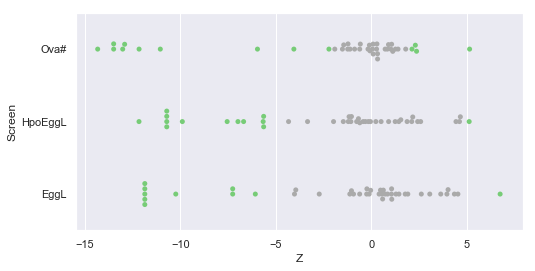

In [187]:
fig = plt.figure(figsize=(8,4))
d = data[((data['Z'].abs() < 2) & (data['Screen'] == 'Ova#')) | ((data['Z'].abs() < 5) & (data['Screen'] != 'Ova#'))]
sns.swarmplot(data=d, x='Z', y='Screen', color=gray)
d = data[((data['Z'].abs() >= 2) & (data['Screen'] == 'Ova#')) | ((data['Z'].abs() >= 5) & (data['Screen'] != 'Ova#'))]
sns.swarmplot(data=d, x='Z', y='Screen', color=green)
fig.savefig(os.path.join(resultpath,"Figures", "Pred_Results.svg"))

In [188]:
d_neg = data[((data['Z'].abs() < 2) & (data['Screen'] == 'Ova#')) | ((data['Z'].abs() < 5) & (data['Screen'] != 'Ova#'))]

In [189]:
d_neg.groupby('Screen').count()

,FbID,Z
Screen,,
EggL,32,32
HpoEggL,29,29
Ova#,28,28


In [190]:
d_pos = data[((data['Z'].abs() >= 2) & (data['Screen'] == 'Ova#')) | ((data['Z'].abs() >= 5) & (data['Screen'] != 'Ova#'))]

In [191]:
d_pos.groupby('Screen').count()

,FbID,Z
Screen,,
EggL,10,10
HpoEggL,13,13
Ova#,14,14


In [192]:
PPI_ID = "2018_08"

In [193]:
connectors = pd.read_csv(os.path.join(resultpath,"ConnectorGeneList_{}.csv".format(PPI_ID)))

In [194]:
predrate = d_pos.groupby('Screen').count() / data.groupby('Screen').count()

In [195]:
predrate = predrate.reset_index()

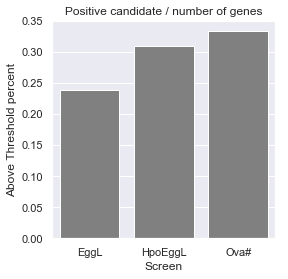

In [196]:
fig = plt.figure(figsize=(4,4))
sns.barplot(data=predrate, x='Screen', y='Z', color="Gray")
plt.title("Positive candidate / number of genes")
plt.ylabel('Above Threshold percent')
fig.savefig(os.path.join(resultpath, "Pred_inscreen_percent_above_thresh.svg"))
fig.savefig(os.path.join(resultpath, "Pred_inscreen_percent_above_thresh.png"))
fig.savefig(os.path.join(resultpath, "Pred_inscreen_percent_above_thresh.pdf"))

In [197]:
d = data[(data['FbID'].isin(connectors[connectors['Module'] == 'Ova']['FbID'].values)) & (data['Screen'] == 'Ova#')]

In [198]:
ova_pred= len(d[d['Z'].abs() >= 2])/len(d)
ova_pred_tot= len(d[d['Z'].abs() >= 2])


In [199]:
len(d)

11

In [200]:
d = data[(data['FbID'].isin(connectors[connectors['Module'] == 'HpoFec']['FbID'].values)) & (data['Screen'] == 'HpoEggL')]

In [201]:
hpoeggl_pred= len(d[d['Z'].abs() >= 5])/len(d)
hpoeggl_pred_tot= len(d[d['Z'].abs() >= 5])


In [202]:
len(d)

17

In [203]:
d[d['Z'].abs() >= 5]

,FbID,Screen,Z
47,FBgn0003041,HpoEggL,-12.156343
55,FBgn0011726,HpoEggL,-10.703588
60,FBgn0016917,HpoEggL,-10.703588
63,FBgn0023540,HpoEggL,-10.703588
71,FBgn0035640,HpoEggL,-5.655873
72,FBgn0036136,HpoEggL,-10.703588
80,FBgn0043903,HpoEggL,-5.630508


In [204]:
d = data[(data['FbID'].isin(connectors[connectors['Module'] == 'xRNAiFec']['FbID'].values)) & (data['Screen'] == 'EggL')]

In [205]:
eggl_pred= len(d[d['Z'].abs() >= 5])/len(d)
eggl_pred_tot= len(d[d['Z'].abs() >= 5])
eggl_genes = set(d['FbID'].values)

In [206]:
len(d)

11

In [207]:
results = [
    ['Ova#', ova_pred, ova_pred_tot],
    ['HpoEggL', hpoeggl_pred, hpoeggl_pred_tot],
    ['EggL', eggl_pred, eggl_pred_tot]
]
results = pd.DataFrame(results, columns=['Screen', 'Prediction Rate', 'Total nb genes'])

In [208]:
results

,Screen,Prediction Rate,Total nb genes
0,Ova#,0.272727,3
1,HpoEggL,0.411765,7
2,EggL,0.000000,0


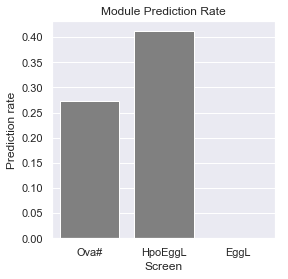

In [209]:

fig = plt.figure(figsize=(4,4))
sns.barplot(data=results, x='Screen', y='Prediction Rate', color="Gray")
plt.title("Module Prediction Rate")
plt.ylabel('Prediction rate')
fig.savefig(os.path.join(resultpath, "Pred_Module_rate.svg"))
fig.savefig(os.path.join(resultpath, "Pred_Module_rate.png"))
fig.savefig(os.path.join(resultpath, "Pred_Module_rate.pdf"))

In [210]:
len(connectors[connectors['Module'] == 'Core']['FbID'].values)

10

In [211]:
d = data[data['Screen'] == 'Ova#']
ova_genes= set(d[d['Z'].abs() >= 2]['FbID'])
d = data[data['Screen'] == 'HpoEggL']
hpoeggl_genes= set(d[d['Z'].abs() >= 5]['FbID'])
d = data[data['Screen'] == 'EggL']
eggl_genes= set(d[d['Z'].abs() >= 5]['FbID'])

In [212]:
print("Number of Core Positive genes accorss all tested genes (not module restricted)")
len(set.intersection(ova_genes, hpoeggl_genes, eggl_genes))

Number of Core Positive genes accorss all tested genes (not module restricted)


8

In [213]:
d = data[(data['FbID'].isin(connectors[connectors['Module'] == 'Core']['FbID'].values))]

In [214]:
d_pos = d[((d['Z'].abs() >= 2) & (d['Screen'] == 'Ova#')) | ((d['Z'].abs() >= 5) & (d['Screen'] != 'Ova#'))]

In [215]:
core_pred = d_pos.groupby('Screen').count()/d.groupby('Screen').count()
core_pred_tot = d_pos.groupby('Screen').count()

In [216]:
core_pred_tot

,FbID,Z
Screen,,
EggL,1,1
HpoEggL,2,2
Ova#,5,5


In [217]:
core_pred = core_pred.reset_index()

In [218]:
toadd = pd.DataFrame([['All3', 0.1, 0.1]], columns=core_pred.columns)
core_pred = core_pred.append(toadd)

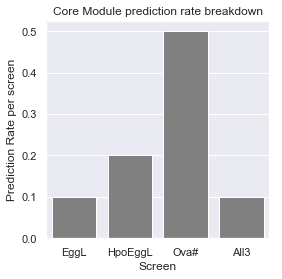

In [219]:
fig = plt.figure(figsize=(4,4))

sns.barplot(data=core_pred, x='Screen', y='Z', color='Gray')
plt.ylabel('Prediction Rate per screen')
plt.title("Core Module prediction rate breakdown")
fig.savefig(os.path.join(resultpath, "Pred_Core_Module_breakdown.svg"))
fig.savefig(os.path.join(resultpath, "Pred_Core_Module_breakdown.png"))
fig.savefig(os.path.join(resultpath, "Pred_Core_Module_breakdown.pdf"))

In [ ]:
screen_background_pred = [
    "EggL": 273-
]

In [88]:
len(Zposneg_xRNAi)

10

# Prediction accuracy with connector removed if |Z| < 1 in the Hpo Eggl 

In [220]:
data = mean_ova_gene[['FbID','Z']].merge(mean_fec_gene[['FbID','Z']], on='FbID').merge(mean_xRNAi_gene[['FbID','Z']], on='FbID')

In [221]:
data.columns = ['FbID', 'Ova#', 'HpoEggL', 'EggL']

In [222]:
data = data.melt(id_vars =['FbID'])  

In [223]:
data = data[data['FbID'] != 'Control']

In [224]:
data.columns = ['FbID', 'Screen', 'Z']

In [225]:
gray = "#AAAAAA"
green = "#77cc77"

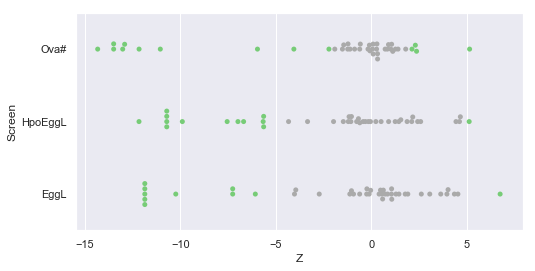

In [226]:
fig = plt.figure(figsize=(8,4))
d = data[((data['Z'].abs() < 2) & (data['Screen'] == 'Ova#')) | ((data['Z'].abs() < 5) & (data['Screen'] != 'Ova#'))]
sns.swarmplot(data=d, x='Z', y='Screen', color=gray)
d = data[((data['Z'].abs() >= 2) & (data['Screen'] == 'Ova#')) | ((data['Z'].abs() >= 5) & (data['Screen'] != 'Ova#'))]
sns.swarmplot(data=d, x='Z', y='Screen', color=green)
fig.savefig(os.path.join(resultpath,"Figures", "Pred_Results.svg"))

In [227]:
to_keep = data[(data["Screen"] == "HpoEggL") & (data['Z'].abs() > 1)]['FbID']
data = pd.concat([data[(data['FbID'].isin(to_keep)) & (data["Screen"] != "HpoEggL")], data[(data["Screen"] == "HpoEggL")]])

In [228]:
d_neg = data[((data['Z'].abs() < 2) & (data['Screen'] == 'Ova#')) | ((data['Z'].abs() < 5) & (data['Screen'] != 'Ova#'))]

In [229]:
d_neg.groupby('Screen').count()

,FbID,Z
Screen,,
EggL,22,22
HpoEggL,29,29
Ova#,20,20


In [230]:
d_pos = data[((data['Z'].abs() >= 2) & (data['Screen'] == 'Ova#')) | ((data['Z'].abs() >= 5) & (data['Screen'] != 'Ova#'))]

In [231]:
d_pos.groupby('Screen').count()

,FbID,Z
Screen,,
EggL,10,10
HpoEggL,13,13
Ova#,12,12


In [232]:
PPI_ID = "2018_08"

In [233]:
connectors = pd.read_csv(os.path.join(resultpath,"ConnectorGeneList_{}.csv".format(PPI_ID)))

In [234]:
predrate = d_pos.groupby('Screen').count() / data.groupby('Screen').count()

In [235]:
predrate = predrate.reset_index()

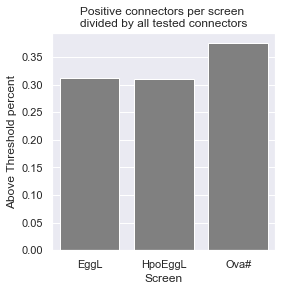

In [236]:
fig = plt.figure(figsize=(4,4))
sns.barplot(data=predrate, x='Screen', y='Z', color="Gray")
plt.title("Positive connectors per screen \ndivided by all tested connectors")
plt.ylabel('Above Threshold percent')
fig.savefig(os.path.join(resultpath, "Pred_inscreen_percent_above_thresh.svg"))
fig.savefig(os.path.join(resultpath, "Pred_inscreen_percent_above_thresh.png"))
fig.savefig(os.path.join(resultpath, "Pred_inscreen_percent_above_thresh.pdf"))

In [237]:
d = data[(data['FbID'].isin(connectors[connectors['Module'] == 'Ova']['FbID'].values)) & (data['Screen'] == 'Ova#')]

In [238]:
ova_pred= len(d[d['Z'].abs() >= 2])/len(d)
ova_pred_tot= len(d[d['Z'].abs() >= 2])


In [239]:
len(d)

7

In [240]:
d = data[(data['FbID'].isin(connectors[connectors['Module'] == 'HpoFec']['FbID'].values)) & (data['Screen'] == 'HpoEggL')]

In [241]:
hpoeggl_pred= len(d[d['Z'].abs() >= 5])/len(d)
hpoeggl_pred_tot= len(d[d['Z'].abs() >= 5])


In [242]:
len(d)

17

In [243]:
d[d['Z'].abs() >= 5]

,FbID,Screen,Z
47,FBgn0003041,HpoEggL,-12.156343
55,FBgn0011726,HpoEggL,-10.703588
60,FBgn0016917,HpoEggL,-10.703588
63,FBgn0023540,HpoEggL,-10.703588
71,FBgn0035640,HpoEggL,-5.655873
72,FBgn0036136,HpoEggL,-10.703588
80,FBgn0043903,HpoEggL,-5.630508


In [244]:
d = data[(data['FbID'].isin(connectors[connectors['Module'] == 'xRNAiFec']['FbID'].values)) & (data['Screen'] == 'EggL')]

In [245]:
eggl_pred= len(d[d['Z'].abs() >= 5])/len(d)
eggl_pred_tot= len(d[d['Z'].abs() >= 5])
eggl_genes = set(d['FbID'].values)

In [246]:
len(d)

10

In [247]:
results = [
    ['Ova#', ova_pred, ova_pred_tot],
    ['HpoEggL', hpoeggl_pred, hpoeggl_pred_tot],
    ['EggL', eggl_pred, eggl_pred_tot]
]
results = pd.DataFrame(results, columns=['Screen', 'Prediction Rate', 'Total nb genes'])

In [248]:
results

,Screen,Prediction Rate,Total nb genes
0,Ova#,0.285714,2
1,HpoEggL,0.411765,7
2,EggL,0.000000,0


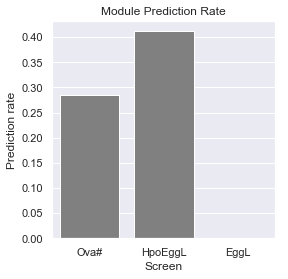

In [249]:

fig = plt.figure(figsize=(4,4))
sns.barplot(data=results, x='Screen', y='Prediction Rate', color="Gray")
plt.title("Module Prediction Rate")
plt.ylabel('Prediction rate')
fig.savefig(os.path.join(resultpath, "Pred_Module_rate.svg"))
fig.savefig(os.path.join(resultpath, "Pred_Module_rate.png"))
fig.savefig(os.path.join(resultpath, "Pred_Module_rate.pdf"))

In [250]:
len(connectors[connectors['Module'] == 'Core']['FbID'].values)

10

In [251]:
d = data[data['Screen'] == 'Ova#']
ova_genes= set(d[d['Z'].abs() >= 2]['FbID'])
d = data[data['Screen'] == 'HpoEggL']
hpoeggl_genes= set(d[d['Z'].abs() >= 5]['FbID'])
d = data[data['Screen'] == 'EggL']
eggl_genes= set(d[d['Z'].abs() >= 5]['FbID'])

In [252]:
print("Number of Core Positive genes accorss all tested genes (not module restricted)")
len(set.intersection(ova_genes, hpoeggl_genes, eggl_genes))

Number of Core Positive genes accorss all tested genes (not module restricted)


8

In [253]:
d = data[(data['FbID'].isin(connectors[connectors['Module'] == 'Core']['FbID'].values))]

In [254]:
d_pos = d[((d['Z'].abs() >= 2) & (d['Screen'] == 'Ova#')) | ((d['Z'].abs() >= 5) & (d['Screen'] != 'Ova#'))]

In [255]:
core_pred = d_pos.groupby('Screen').count()/d.groupby('Screen').count()
core_pred_tot = d_pos.groupby('Screen').count()

In [256]:
core_pred_tot

,FbID,Z
Screen,,
EggL,1,1
HpoEggL,2,2
Ova#,4,4


In [257]:
core_pred = core_pred.reset_index()

In [258]:
toadd = pd.DataFrame([['All3', 0.1, 0.1]], columns=core_pred.columns)
core_pred = core_pred.append(toadd)

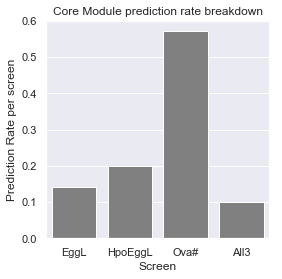

In [259]:
fig = plt.figure(figsize=(4,4))

sns.barplot(data=core_pred, x='Screen', y='Z', color='Gray')
plt.ylabel('Prediction Rate per screen')
plt.title("Core Module prediction rate breakdown")
fig.savefig(os.path.join(resultpath, "Pred_Core_Module_breakdown.svg"))
fig.savefig(os.path.join(resultpath, "Pred_Core_Module_breakdown.png"))
fig.savefig(os.path.join(resultpath, "Pred_Core_Module_breakdown.pdf"))

# Calculating the binomial test p-value to see if the predictions has a higher than expected probability 

In [330]:
from scipy.stats import binom_test

In [353]:
data = mean_ova_gene[['FbID','Z']].merge(mean_fec_gene[['FbID','Z']], on='FbID').merge(mean_xRNAi_gene[['FbID','Z']], on='FbID')
data.columns = ['FbID', 'Ova#', 'HpoEggL', 'EggL']
data = data.melt(id_vars =['FbID'])  
data = data[data['FbID'] != 'Control']
data.columns = ['FbID', 'Screen', 'Z']
to_keep = data[(data["Screen"] == "HpoEggL") & (data['Z'].abs() > 1)]['FbID']
data = pd.concat([data[(data['FbID'].isin(to_keep)) & (data["Screen"] != "HpoEggL")], data[(data["Screen"] == "HpoEggL")]])
d_neg = data[((data['Z'].abs() < 2) & (data['Screen'] == 'Ova#')) | ((data['Z'].abs() < 5) & (data['Screen'] != 'Ova#'))]
d_pos = data[((data['Z'].abs() >= 2) & (data['Screen'] == 'Ova#')) | ((data['Z'].abs() >= 5) & (data['Screen'] != 'Ova#'))]
predrate = d_pos.groupby('Screen').count() / data.groupby('Screen').count()
predrate = predrate.reset_index()

In [354]:
ova_pos = d_pos[d_pos['Screen'] == "Ova#"]['FbID'].values
fec_pos = d_pos[d_pos['Screen'] == "HpoEggL"]['FbID'].values
xRNAi_pos = d_pos[d_pos['Screen'] == "EggL"]['FbID'].values

In [355]:
core_pos = set.intersection(set(xRNAi_pos), set(ova_pos), set(fec_pos))

In [369]:
core_predrate = [['Core', len(core_pos)/len(data[data['Screen'] == 'EggL']), len(core_pos)/len(data[data['Screen'] == 'EggL'])]]
core_predrate = pd.DataFrame(core_predrate, columns=predrate.columns)

In [371]:
predrate = predrate.append(core_predrate).reset_index(drop=True)

In [275]:
data_path = '../Data/'

In [373]:
# We load the CSV files we just created
hipo_ova_screen = pd.read_csv(os.path.join(data_path, 'Screen', 'hipo_ova_clean.csv'))
hipo_fec_screen = pd.read_csv(os.path.join(data_path, 'Screen', 'hipo_fec_clean.csv'))
xRNAi_fec_screen = pd.read_csv(os.path.join(data_path, 'Screen', 'xRNAi_fec_clean.csv'))

In [374]:
# Next we calculate all the Zscore means 
# We group the dataset by gene (FbID) and we take the mean for each.

# Ovariole number screen
mean_ova_gene_screen = hipo_ova_screen.groupby('FbID', as_index=False).mean()

# Here we only consider the sum of egg layed for 5 days

# Hippo RNAi Egg Laying screen
mean_fec_gene_screen = hipo_fec_screen[hipo_fec_screen['Condition'] == 'Sum'].groupby('FbID', as_index=False).mean()

# Egg Laying Screen
mean_xRNAi_gene_screen = xRNAi_fec_screen[xRNAi_fec_screen['Condition'] == 'Sum'].groupby('FbID', as_index=False).mean()


In [375]:
# We define the thresholds for selecting a candidate 
# Ovariole number at 2 and EggL at 5
ova_threshold = 2
eggl_threshold = 5

In [294]:
# Ovariole number screen
# Keep only genes with a Zscore over or equal to 2
Zposneg_ova_screen = mean_ova_gene_screen[(mean_ova_gene_screen['Z'].abs()>=ova_threshold)]['FbID'].values
# Filter out the controls
Zposneg_ova_screen = [i for i in Zposneg_ova_screen if 'FBgn' in i]

# Hippo RNAi Egg Laying screen
# Keep only genes with a Zscore over or equal to 5
Zposneg_fec_screen = mean_fec_gene_screen[(mean_fec_gene_screen['Z'].abs()>=eggl_threshold)]['FbID'].values
# Filter out the controls
Zposneg_fec_screen = [i for i in Zposneg_fec_screen if 'FBgn' in i]

# Egg Laying Screen
# Keep only genes with a Zscore over or equal to 5
Zposneg_xRNAi_screen = mean_xRNAi_gene_screen[(mean_xRNAi_gene_screen['Z'].abs()>=eggl_threshold)]['FbID'].values
# Filter out the controls
Zposneg_xRNAi_screen = [i for i in Zposneg_xRNAi_screen if 'FBgn' in i]

In [376]:
core_posneg = set.intersection(set(Zposneg_ova_screen), set(Zposneg_fec_screen), set(Zposneg_xRNAi_screen))

In [378]:
len(core_posneg)

27

In [379]:
screen_background_pred = [
    ["EggL", len(Zposneg_xRNAi_screen)/(len(mean_xRNAi_gene_screen['FbID'].unique()) - 1)],
    ["HpoEggL", len(Zposneg_fec_screen)/(len(mean_fec_gene_screen['FbID'].unique()) - 1)],
    ["Ova#", len(Zposneg_ova_screen)/(len(mean_ova_gene_screen['FbID'].unique()) - 1)],
    ["Core", len(core_posneg)/(len(mean_ova_gene_screen['FbID'].unique()) - 1)]
]

In [380]:
screen_background_pred = pd.DataFrame(screen_background_pred, columns=['Screen', 'Prediction Rate'])
screen_background_pred

,Screen,Prediction Rate
0,EggL,0.179487
1,HpoEggL,0.127430
2,Ova#,0.245421
3,Core,0.098901


In [381]:
predrate

,Screen,FbID,Z
0,EggL,0.312500,0.312500
1,HpoEggL,0.309524,0.309524
2,Ova#,0.375000,0.375000
3,Core,0.250000,0.250000


In [384]:
for screen in screen_background_pred['Screen']:
    if screen != 'Core':
        pos = len(d_pos[d_pos['Screen'] == screen])
        trials = len(data[data['Screen'] == screen])
    else:
        pos = len(core_pos)
        trials = 32
    p = screen_background_pred[screen_background_pred['Screen'] == screen]['Prediction Rate'].values[0]
    print(screen, binom_test(pos, trials, p, alternative='greater'))

EggL 0.0485435124625
HpoEggL 0.00161476408325
Ova# 0.0714195303891
Core 0.0109652569482


### New version of Figure 7 merging c and d

In [385]:
predrate['Prediction Rate'] = predrate['Z']

In [386]:
del predrate['FbID']
del predrate['Z']

In [387]:
predrate['Type'] = "Predicted"
screen_background_pred['Type'] = "Signaling Screen"

In [388]:
d = predrate.append(screen_background_pred)

In [389]:
d

,Screen,Prediction Rate,Type
0,EggL,0.312500,Predicted
1,HpoEggL,0.309524,Predicted
2,Ova#,0.375000,Predicted
3,Core,0.250000,Predicted
0,EggL,0.179487,Signaling Screen
1,HpoEggL,0.127430,Signaling Screen
2,Ova#,0.245421,Signaling Screen
3,Core,0.098901,Signaling Screen


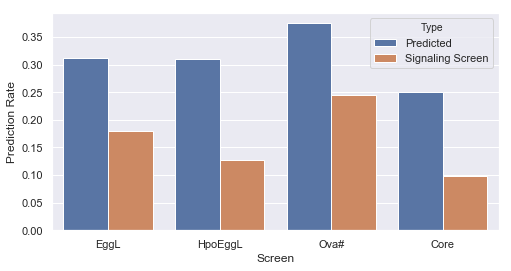

In [390]:
fig = plt.figure(figsize=(8, 4))

sns.barplot(data=d, x="Screen", y="Prediction Rate", hue="Type")

fig.savefig(os.path.join(resultpath, "Figures", "Pred_Screen_VS_Predicted.svg"))

In [ ]:
sns.barplot(data=core_pred, x='Screen', y='Z', color='Gray')
plt.ylabel('Prediction Rate per screen')
plt.title("Core Module prediction rate breakdown")
fig.savefig(os.path.join(resultpath, "Pred_Core_Module_breakdown.png"))
fig.savefig(os.path.join(resultpath, "Pred_Core_Module_breakdown.pdf"))